In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
# First, we get the data
path = r"C:\Users\yanzh\Desktop\Deep learning\Stock Prices Prediction Project\AABA_2006-01-01_to_2018-01-01.csv"
dataset = pd.read_csv(path, index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [3]:
# Checking for missing values

training_set = dataset[:'2016'].iloc[:, 1:2].values
test_set = dataset['2017':].iloc[:, 1:2].values

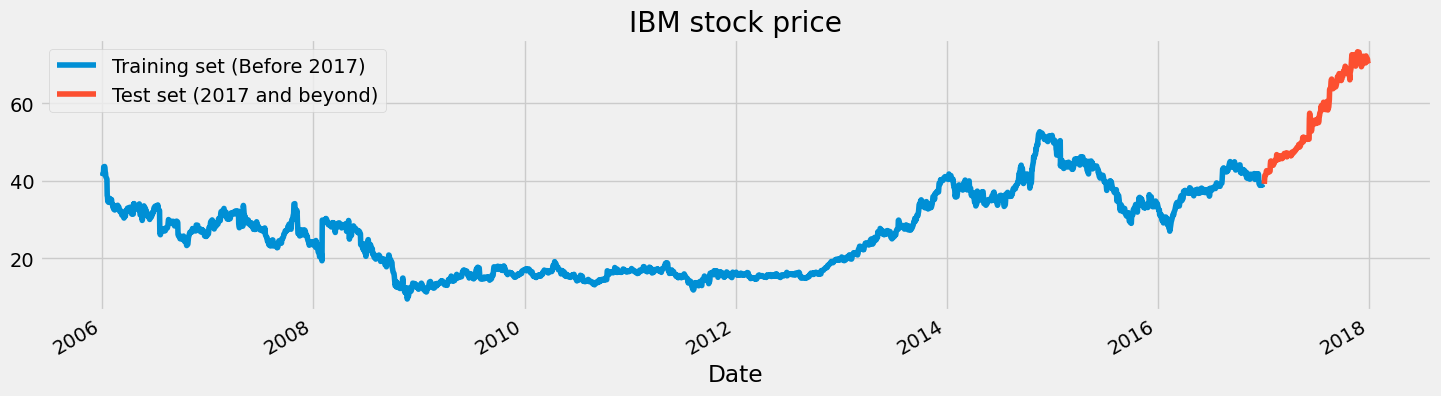

In [4]:
# We have chosen 'high' attribute for prices, let's see what it looks like
dataset['High'][:'2016'].plot(figsize=(16, 4), legend=True)
dataset['High']['2017':].plot(figsize=(16, 4), legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [29]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
# Scaling the training set

sc = MinMaxScaler(feature_range=(0, 1))
"""
This instance sc will be used to both compute the minimun and maximum values of the data and to scale the data.
"""

training_set_scaled = sc.fit_transform(training_set)

In [8]:
training_set

array([[41.22],
       [41.9 ],
       [41.73],
       ...,
       [39.22],
       [38.93],
       [39.  ]])

In [6]:
# Since LSTM store long term memory state, we create a data structure with 60 timesteps and 1 output

X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
# Reshaping X_train for efficient modelling
"""
LSTM network expect input data to be in a specific format, typically a three-dimensional array with the shape (batch_size, timesteps, features)
    'batch_size' refers to the number of samples in a batch
    'timesteps' is a dimension that represents the sequence length, in this case, it is 60
    'features' refers to the number of indicators or predictors that have for each timestep

np.shape() is a numpy function used to change the shape of an array without changing its data
"""
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))


In [18]:
# The LSTM architecture
"""
Sequential models are a linear stack of layers, this model type is suitable for a plain stack of layers where each layer has exactly one input
and one output tensor
"""
regressor = Sequential()

# Adding LSTM layers and dropout regularisation
""" 
This line adds an LSTM layer to the model with 50 unit, the 'return_sequences=True' parameter  is crucial as it allows the LSTM layer to return the full 
sequence to the next layer instead of just the output of the last timestep, this is needed when stacking LSTM layers.
"""
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))

""" 
This layer is added to prevent overfitting. Dropout randomly sets a fraction 0.2 here
"""
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))


""" 
This is the output layer of the network with a single neuron
"""
# The output layer
regressor.add(Dense(units=1))

# Compiling the Model
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0274
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0071
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0056
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0050
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0048
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0040
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0036
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0033
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0031
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0032
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0030
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0026
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0024
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0022
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0026
Epoch 16/50
85/

In [36]:
# Now to get the test set ready in similar way as the training set
dataset_total = pd.concat((dataset['High'][:'2016'], dataset['High']['2017':]), axis=0)

""" 
This line of code selects last 60 days of 2016, becasue they are needed as the initial sequence of timesteps to predict the first day of 2017
"""
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1) #
inputs  = sc.transform(inputs)

In [45]:
# Preparing X_test and predicting the prices

X_test = []
for i in range(60, 311):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)

""" 
Inverse Scalling: the predictions made by the model are in the scaled format(as the model was trained on scaled data).
To covert these predictions back to the original stock price scale, we need use the inverse transform method 
"""

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


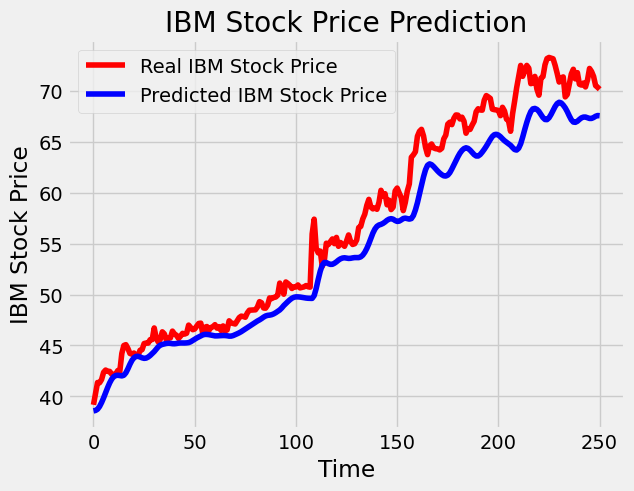

In [46]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [47]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.8668540644469847.
